In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
}

<IPython.core.display.Javascript object>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

# EDA & Feature Engineering of Continuous Variables

The label for this competition is the log transformation of SalePrice. Let's derive this column before we start exploring its relationship with other variables. Let's also plot the distributions of the original and transformed label columns:

In [3]:
train['log_SalePrice'] = np.log(train['SalePrice'])

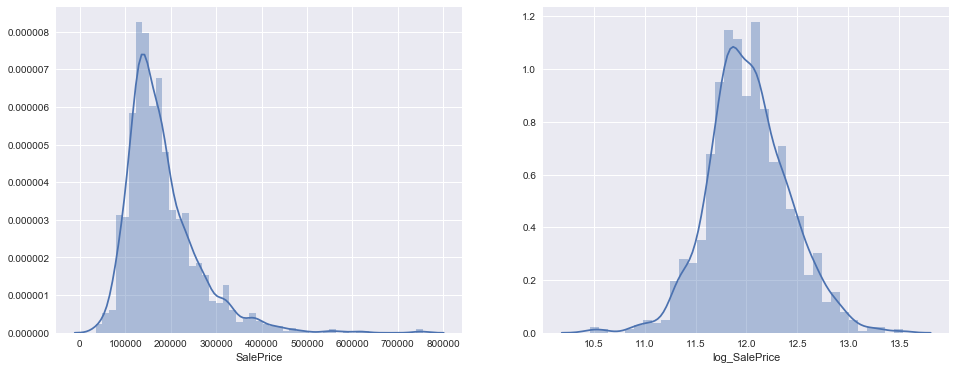

In [4]:
f, axs = sns.plt.subplots(1, 2)
f.set_size_inches(16,6)
label_columns = ['SalePrice', 'log_SalePrice']
for i in range(2):
    sns.distplot(train[label_columns[i]], ax=axs[i])

Great. The log-transformed SalePrice is more normally distributed than the original column.

Let's get the list of columns that are not of type 'object' (strings). These are likely our continuous features:

In [5]:
continuous_features = train.columns[train.dtypes != object].tolist()
continuous_features

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'log_SalePrice']

Looking at the data_description.txt files, a few of these columns are actually categorical features that are labeled with numbers. We'll filter those out, and we'll also filter out the SalePrice and Id columns. ** (identify and describe the aforementioned categorical features)**

In [1]:
for col in ['Id', 'SalePrice', 'MSSubClass', 'OverallQual', 'OverallCond']:
    continuous_features.remove(col)

print('Continuous Features:\n')
print('\n'.join(continuous_features))

NameError: name 'continuous_features' is not defined

Now let's look at a clustered correlation heatmap to see what continuous features are correlated with each other and log_SalePrice:

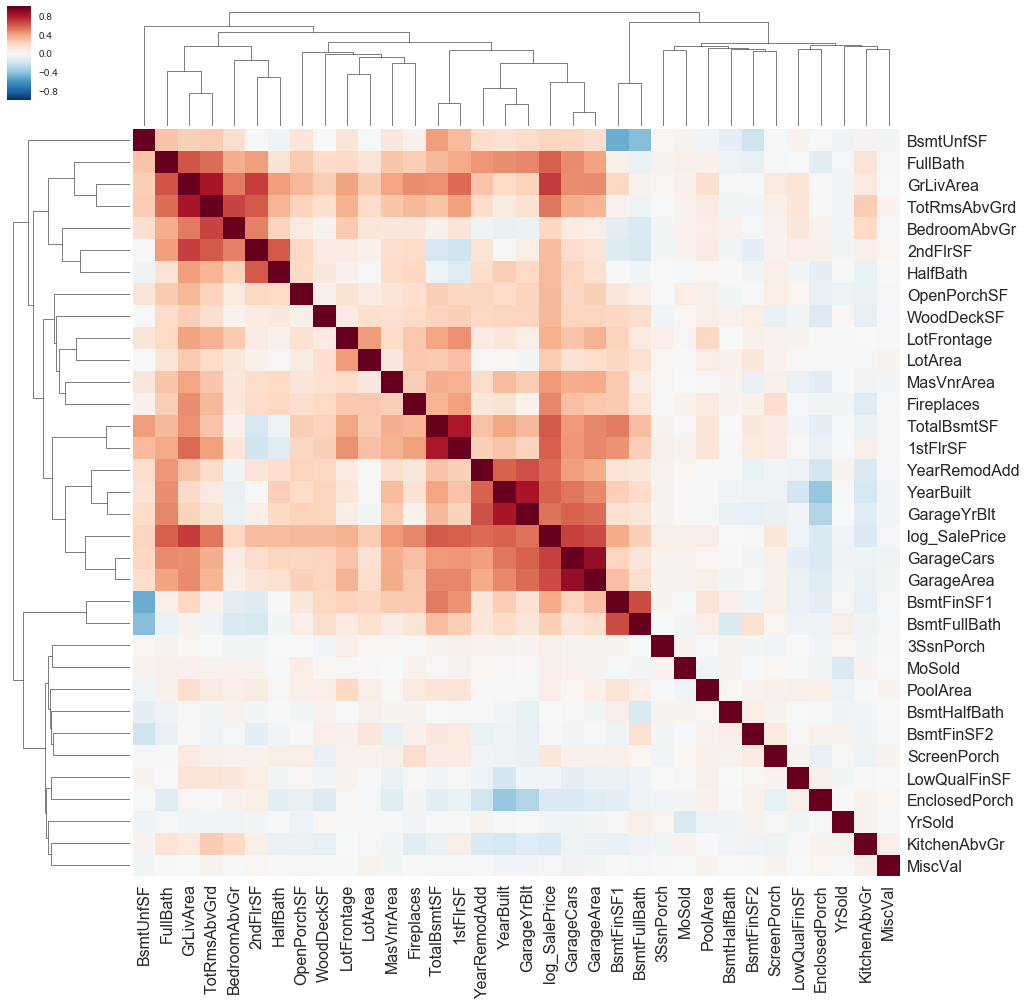

In [7]:
corrmat = train[continuous_features].corr()

cg = sns.clustermap(data=corrmat, figsize=(16, 16))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=16)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=16)
plt.show()

At first glance, it looks like only a subset of these features actually matter. Many of the features are uncorrelated with each other and with log_SalePrice. We'll ignore those features for now, but they're certainly worth revisiting. For instance MiscVal corresponds with the MiscFeature column. We may need to engineer new features based on a combination of those two columns in order to see a relationship with log_SalePrice.

We'll examine the subset of features in the top left cluster:

In [8]:
clustered_features = [label.get_text() for label in cg.ax_heatmap.xaxis.get_majorticklabels()]
important_features = clustered_features[:21]
important_features

['BsmtUnfSF',
 'FullBath',
 'GrLivArea',
 'TotRmsAbvGrd',
 'BedroomAbvGr',
 '2ndFlrSF',
 'HalfBath',
 'OpenPorchSF',
 'WoodDeckSF',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'Fireplaces',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'YearBuilt',
 'GarageYrBlt',
 'log_SalePrice',
 'GarageCars',
 'GarageArea']

Let's remake the clustered correlation heatmap with just this subset of features:

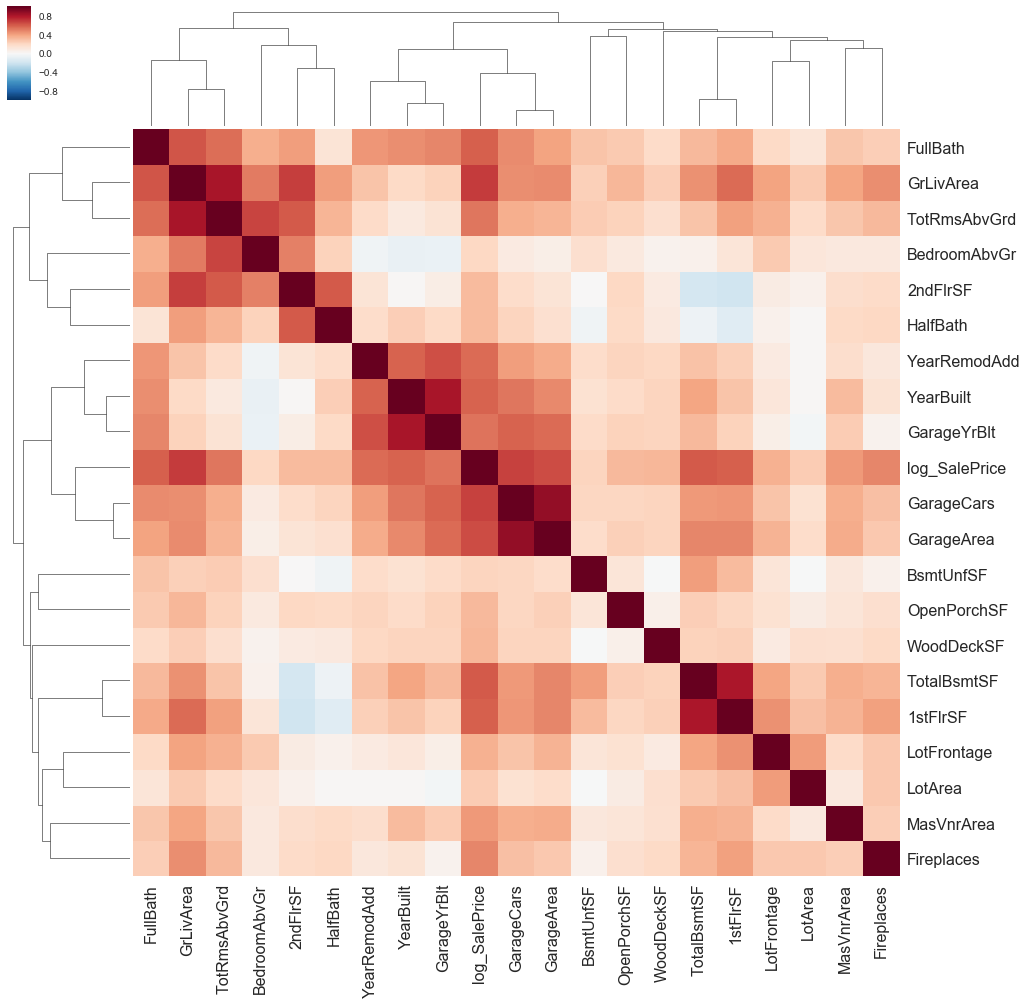

In [9]:
important_corrmat = train[important_features].corr()

cg2 = sns.clustermap(data=important_corrmat, figsize=(16, 16))
plt.setp(cg2.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=16)
plt.setp(cg2.ax_heatmap.xaxis.get_majorticklabels(), fontsize=16)
plt.show()

Two of these features, YearRemodAdd and YearBuilt, are yearly. Let's subtract the minimum years from those so that their minimum values are zero:

In [10]:
for feat in ['YearRemodAdd', 'YearBuilt']:
    train[feat + '_rescaled'] = train[feat] - train[feat].min()
    important_features.remove(feat)
    important_features.append(feat + '_rescaled')

Now let's look at scatter/regression plots of the features with the label to see the relationships:

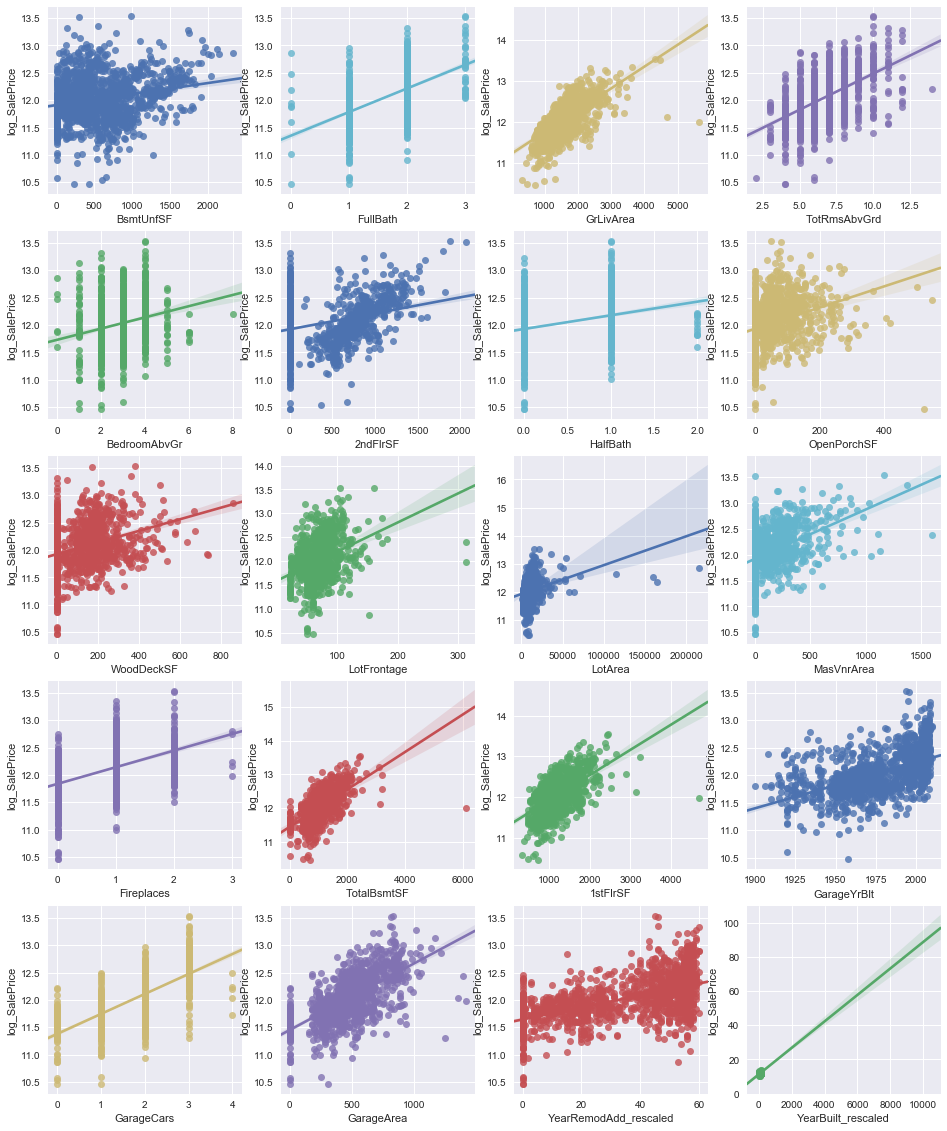

In [11]:
# Remove the label from the feature list because it's not a feature; it's the label
important_features.remove('log_SalePrice')  

# Reshape the feature list into a 5x4 ndarray so we can iterate through it in a grid
important_features_arr = np.array(important_features).reshape(5,4) 

# We'll do a 5x4 grid of subplots since we have 20 features
f, axs = sns.plt.subplots(5,4)
f.set_size_inches(16,20)

for i in range(4):
    for j in range(5):
        sns.regplot(data=train, x=important_features_arr[j,i], y='log_SalePrice', ax=axs[j,i])

Observations:
* There are a few features where the slope is skewed by zero values of the feature. We may be able to benefit by creating slope dummies for those and including them in the model. These features are YearRemodAdd, WoodDeckSF, 2ndFlrSF, MaxVnrArea, TotalBsmtSF, BsmtUnfSF
* A few features have outliers that skew the fit. These features are: 1stFlrSF, LotArea, LotFrontage, TotalBsmtSF, and GrLivArea

To deal with the zero-values in certain features skewing the lienar fit, we'll craft new dummy features that have a value of 1 when the feature is 0, and is 0 otherwise:

In [12]:
zeroval_features = ['YearRemodAdd_rescaled'
                    , 'WoodDeckSF'
                    , '2ndFlrSF'
                    , 'MasVnrArea'
                    , 'TotalBsmtSF'
                    , 'BsmtUnfSF']

for feat in zeroval_features:
    train['{}_zero'.format(feat)] = 0
    train.ix[train[feat] == 0, '{}_zero'.format(feat)] = 1

Let's re-examine the scatter/regression plots of these features with the label, using the new dummy features as the hue:

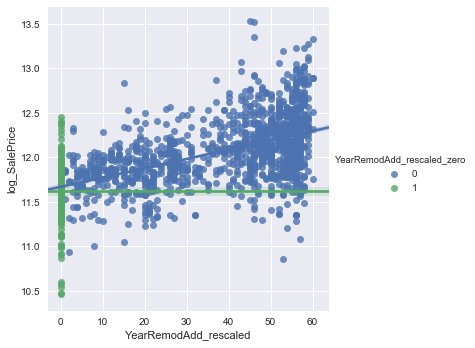

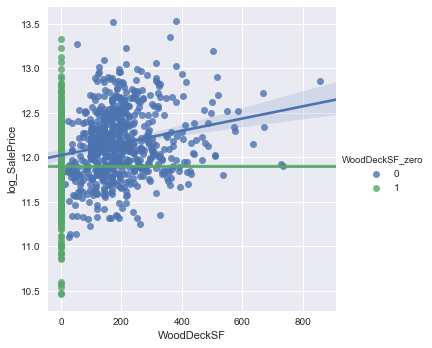

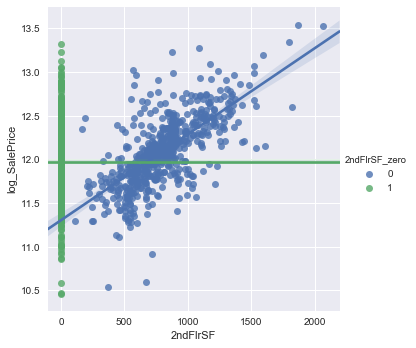

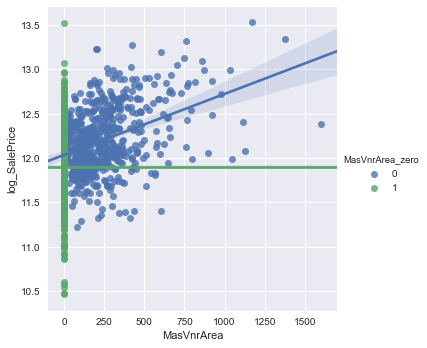

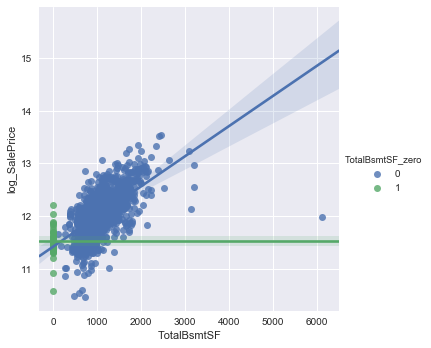

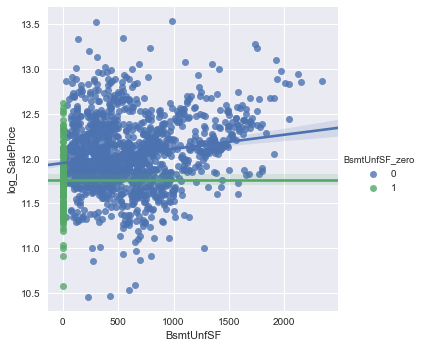

In [13]:
for i in range(len(zeroval_features)):
    sns.lmplot(data=train, y='log_SalePrice', x=zeroval_features[i], hue=zeroval_features[i] + '_zero')

Those look like much better fits. We'll include these new dummy features in our final model.

Let's see if we can improve the linear fits of some of the other features by removing outliers. We'll do this by standardizing the scale of these features using sklearn's StandardScaler, and then we'll remove observations with absolute values greater than 4 (this is arbitrarily chosen).

In [14]:
# Fill in missing values in the LotFrontage column with zeros, because <reasons>
train['LotFrontage'] = train['LotFrontage'].fillna(0)

# Initialize our standard scaler, and fit transform the features we previously identified
stdscaler = StandardScaler()
transformed_feats = stdscaler.fit_transform(train[['1stFlrSF', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'GrLivArea']])

# Craft new column names, and then build a new temp DataFrame with these rescaled features
new_column_names = [f + '_rescaled' for f in ['1stFlrSF', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'GrLivArea']]
train_transformed_feats = pd.DataFrame(transformed_feats, columns=new_column_names)

# Append the temp DataFrame with the train DataFrame
train = pd.concat([train, train_transformed_feats], axis=1)

# Create a new DataFrame with the observatins containing outliers filtered out
train_filtered = train[
      (train['1stFlrSF_rescaled'].abs() <= 4)
    & (train['LotArea_rescaled'].abs() <= 4)
    & (train['LotFrontage_rescaled'].abs() <= 4)
    & (train['TotalBsmtSF_rescaled'].abs() <= 4)
    & (train['GrLivArea_rescaled'].abs() <= 4)
]

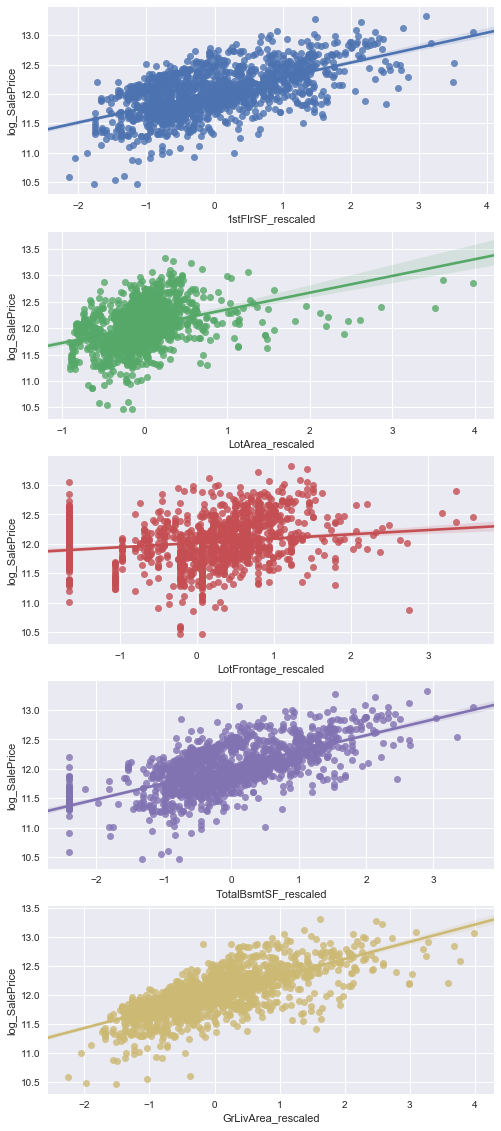

In [16]:
rescaled_feats = new_column_names  # rescaled_feats is a better variable name

f, axs = sns.plt.subplots(len(rescaled_feats),1)
f.set_size_inches(8,20)

for i in range(len(rescaled_feats)):
    sns.regplot(data=train_filtered, x=rescaled_feats[i], y='log_SalePrice', ax=axs[i])

Those look like better fits. We don't see any particular observation skewing the entire line. This filter will be useful for regression models that are sensitive to outliers, e.g. standard Linear Regression or Gradient Boosting Regression.

# Model Fitting

We'll examine the performance of several models in predicting the label:
* Simple Linear Regression
* Random Forest Regression
* Gradient Boosting Regression
* Support Vector Regression with a Gaussian Kernel **(explain what a Gaussian Kernel is)**
* Gaussian Process Regression **(what is this?)**

for each model, we'll identify a set of values for one or more hyperparameters, and then we'll use Cross Validation & Grid Search to find the best set hyperparameters.

In [18]:
train_filtered[columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 1459
Data columns (total 4 columns):
BsmtUnfSF      1441 non-null int64
TotalBsmtSF    1441 non-null int64
MasVnrArea     1433 non-null float64
2ndFlrSF       1441 non-null int64
dtypes: float64(1), int64(3)
memory usage: 56.3 KB


In [19]:
# Filter the MasVnrArea values with zeros
train_filtered['MasVnrArea'] = train_filtered['MasVnrArea'].fillna(0)

# Standard-scale the BsmtUnfSF, TotalBsmtSF, MasVnrArea, and 2ndFlrSF features
columns = ['BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea', '2ndFlrSF']
new_columns = [col + '_rescaled' for col in columns]
stdscaler = StandardScaler()

temp_stdscale = stdscaler.fit_transform(train_filtered[columns])
temp_df = pd.DataFrame(temp_stdscale, columns=new_columns)

train_filtered = pd.concat([train_filtered, temp_df], axis=1)

In [ ]:
predictive_features = ['GrLivArea_rescaled'
                       , 'TotalBsmtSF_rescaled'
                       , 'LotFrontage_rescaled'
                       , 'LotArea_rescaled'
                       , '1stFlrSF_rescaled'
                       , 'BsmtUnfSF_rescaled'
                       , 'BsmtUnfSF_zero'
                       , 'TotalBsmtSF_rescaled'
                       , 'TotalBsmtSF_zero'
                       , 'MasVnrArea_rescaled'
                       , 'MasVnrArea_zero'
                       , '2ndFlrSF_rescaled'
                       , '2ndFlrSF_zero'
                       , 'YearRemodAdd_rescaled'
                       , 'YearRemodAdd_rescaled_zero'
                      ]

X = train_filtered[predictive_features]
y = train_filtered['log_SalePrice']

## Simple Linear Regression

In [ ]:
lr = LinearRegression()
params = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grd = GridSearchCV()